<a href="https://colab.research.google.com/github/Mifekmk/SkillTreePython-DeepLearning/blob/main/01.%EB%94%A5%EB%9F%AC%EB%8B%9Dwith%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0-basic/ch01_05_DNN%EA%B8%B0%EC%B4%88_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch01.05. 딥러닝 다중 분류 모델
---
* 날짜: 2022-07-04
* 이름: 김민규

## 학습내용
    - 딥러닝을 이용한 멀티클래스 분류 진행
    - 적절한 손실함수와 최적화 함수 정의
    - 평가 및 예측
    
## 학습자료

* 모두의딥러닝
* 데이터
  * `iris.csv`
  * MNIST 데이터셋


```
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)
```

```
https://github.com/yebiny/SkillTreePython-DeepLearning.git
```

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning.git

fatal: destination path 'SkillTreePython-DeepLearning' already exists and is not an empty directory.


## 아이리스 꽃 종류 예측
---


```
- 0 sepal_length  꽃받침 길이
- 1 sepal_width 꽃받침 너비
- 2 petal_length 꽃임 길이
- 3 petal_width 꽃잎 너비
- 4 species 꽃의 종류 {setosa, versicolor virginica}
```
<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-01.PNG?raw=true width=550>
</p>


In [3]:
data_path = '/content/SkillTreePython-DeepLearning/dataset/iris.csv'
df = pd.read_csv(data_path, header=None)
df

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Text(0.5, 1.0, 'all dataset')

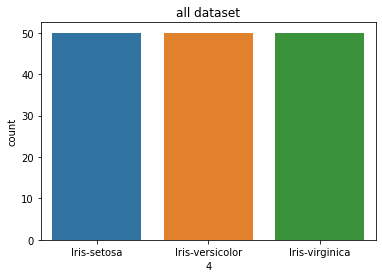

In [4]:
sns.countplot(x=df[4]);plt.title('all dataset')

In [5]:
data_path = '/content/SkillTreePython-DeepLearning/dataset/iris.csv'
df = pd.read_csv(data_path, header=None)
df

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

def iris_preprocess(df, seed=1):
    # x-y 분할
    x = df.values[:, :-1] # values를 통해 넘파이로 변환
    y = df.values[:,-1] # (전체샘플, 마지막 변수)
    # 정규화 (x 데이터만)
    ss = StandardScaler()
    x = ss.fit_transform(x)

    # 원-핫 (y 데이터)
    oh = OneHotEncoder(sparse=False)
    y = oh.fit_transform(np.expand_dims(y, 1)) # 인풋이 무조건 행렬이어야합니다.(150, )->(150,1)
    print(f'원-핫 변환 순서: {oh.categories_}')
    # train-test 분할
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3,
                                                        random_state=seed,
                                                        stratify = y)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = iris_preprocess(df)
print(f'데이터 형태: {x_train.shape}, {x_test.shape}, {y_train.shape}, {y_test.shape}')
print(f'첫 번째 샘플 x : {x_train[0]} y:{y_train[0]}')

원-핫 변환 순서: [array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]
데이터 형태: (105, 4), (45, 4), (105, 3), (45, 3)
첫 번째 샘플 x : [ 0.55333328 -0.58776353  0.76275864  0.39617188] y:[0. 0. 1.]


* 예측값 분포 확인

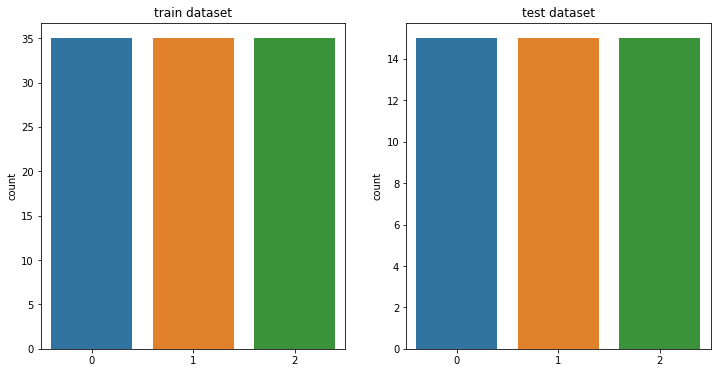

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(121);sns.countplot(x=np.argmax(y_train,axis=1));plt.title('train dataset')
plt.subplot(122);sns.countplot(x=np.argmax(y_test, axis=1));plt.title('test dataset')
plt.show()

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-02.PNG?raw=true width=800>
</p>


#### **모델 생성**

In [7]:
from tensorflow.keras import models, layers, utils

def build_model():
    x = layers.Input(shape=(4,)) # 데이터가 주어지면 인풋의 shape는 고정
    z = layers.Dense(12,activation='relu')(x)
    z = layers.Dense(8,activation='relu')(z)
    y = layers.Dense(3, activation='sigmoid')(z) # 데이터가 주어지면 아웃풋의 shape는 고정 
    # (이진분류문제는 마지막 아웃풋 shape가 1, 마지막 활성함수는 sigmoid를 사용합니다.)
    model = models.Model(x,y, name='iris_classifier')
    return model

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

Model: "iris_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 12)                60        
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


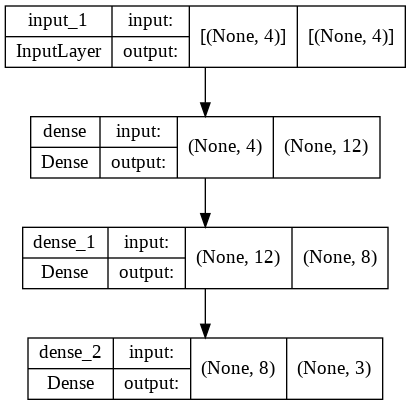

In [8]:
model = build_model()
model.summary()

# 시각화
utils.plot_model(model, show_shapes=True)


### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 다중분류 문제, categorical_crossentropy()
* `optimizer` : 문제와 상관없음, Adam
* `metrics`: 정확도(accuracy)로 설정


In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
# model = Sequential()
# model.add(Dense(16, input_dim=4, activation='relu'))
# model.add(Dense(3, activation='softmax'))

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

In [11]:
model.fit(x_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
105/105 [==============================] - 3s 4ms/step - loss: 1.0995 - accuracy: 0.3333
Epoch 2/100
105/105 [==============================] - 0s 4ms/step - loss: 0.9487 - accuracy: 0.5905
Epoch 3/100
105/105 [==============================] - 0s 4ms/step - loss: 0.8062 - accuracy: 0.6476
Epoch 4/100
105/105 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.6571
Epoch 5/100
105/105 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.6381
Epoch 6/100
105/105 [==============================] - 0s 5ms/step - loss: 0.5386 - accuracy: 0.6571
Epoch 7/100
105/105 [==============================] - 0s 4ms/step - loss: 0.4951 - accuracy: 0.7238
Epoch 8/100
105/105 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.8095
Epoch 9/100
105/105 [==============================] - 1s 5ms/step - loss: 0.4220 - accuracy: 0.8952
Epoch 10/100
105/105 [==============================] - 0s 4ms/step - loss: 0.3879 - accura

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [12]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 1.0000


[0.038882967084646225, 1.0]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [32]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])
# 원핫 -> 라벨
y_pred = np.argmax(y_pred, axis=1) # 벡터화
y_test = np.argmax(y_test, axis=1)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])

ValueError: ignored

* 예측 시각화

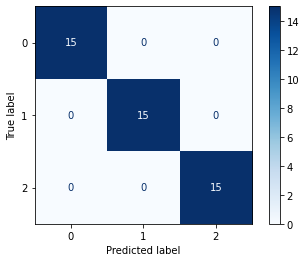

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
#print(cm)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## 과제
---

### | 과제1. 다중분류 문제 정리

* 예측값의 범위 : 0~1
* 예측값의 shape : (input 개수, class 개수)
* 아웃풋 레이어의 노드 개수 : class 개수
* 아웃풋 레이어의 activation : softmax
* 손실함수 (loss) : Categorical_crossentropy, 
* Sparse_Categorical_Crossentropy
* 평가함수 (metrics) : accuracy

### | 과제2. 한 셀에 코드 정리하기

* 추가 연습
  * 모델의 깊이(depth)를 늘려가며 학습해 보세요.
  * 모델의 너비(width)를 늘려가며 학습해 보세요.

In [35]:
data_path = '/content/SkillTreePython-DeepLearning/dataset/iris.csv'
df = pd.read_csv(data_path, header=None)
df

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

def iris_preprocess(df, seed=1):
    # x-y 분할
    x = df.values[:, :-1] # values를 통해 넘파이로 변환
    y = df.values[:,-1] # (전체샘플, 마지막 변수)
    # 정규화 (x 데이터만)
    ss = StandardScaler()
    x = ss.fit_transform(x)

    # 원-핫 (y 데이터)
    oh = OneHotEncoder(sparse=False)
    y = oh.fit_transform(np.expand_dims(y, 1)) # 인풋이 무조건 행렬이어야합니다.(150, )->(150,1)
    print(f'원-핫 변환 순서: {oh.categories_}')
    # train-test 분할
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3,
                                                        random_state=seed,
                                                        stratify = y)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = iris_preprocess(df)
print(f'데이터 형태: {x_train.shape}, {x_test.shape}, {y_train.shape}, {y_test.shape}')
print(f'첫 번째 샘플 x : {x_train[0]} y:{y_train[0]}')

원-핫 변환 순서: [array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]
데이터 형태: (105, 4), (45, 4), (105, 3), (45, 3)
첫 번째 샘플 x : [ 0.55333328 -0.58776353  0.76275864  0.39617188] y:[0. 0. 1.]


In [36]:
from tensorflow.keras import models, layers, utils

def build_model():
    x = layers.Input(shape=(4,)) # 데이터가 주어지면 인풋의 shape는 고정
    z = layers.Dense(12,activation='relu')(x)
    z = layers.Dense(8,activation='relu')(z)
    z = layers.Dense(12,activation='relu')(z)
    z = layers.Dense(6,activation='relu')(z)
    y = layers.Dense(3, activation='sigmoid')(z) # 데이터가 주어지면 아웃풋의 shape는 고정 
    # (이진분류문제는 마지막 아웃풋 shape가 1, 마지막 활성함수는 sigmoid를 사용합니다.)
    model = models.Model(x,y, name='iris_classifier')
    return model

In [37]:
model = build_model()
model.summary()

# 시각화
utils.plot_model(model, show_shapes=True)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "iris_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 12)                60        
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 12)                108       
                                                                 
 dense_6 (Dense)             (None, 6)                 78        
                                                                 
 dense_7 (Dense)             (None, 3)                 21        
                                                                 
Total params: 371
Trainable params: 371
Non-trainab

In [38]:
model.fit(x_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
105/105 [==============================] - 1s 2ms/step - loss: 1.0500 - accuracy: 0.4000
Epoch 2/100
105/105 [==============================] - 0s 3ms/step - loss: 0.8424 - accuracy: 0.7429
Epoch 3/100
105/105 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.8381
Epoch 4/100
105/105 [==============================] - 0s 3ms/step - loss: 0.4173 - accuracy: 0.8476
Epoch 5/100
105/105 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.8667
Epoch 6/100
105/105 [==============================] - 0s 2ms/step - loss: 0.2628 - accuracy: 0.8667
Epoch 7/100
105/105 [==============================] - 0s 2ms/step - loss: 0.2341 - accuracy: 0.9048
Epoch 8/100
105/105 [==============================] - 0s 3ms/step - loss: 0.2122 - accuracy: 0.9143
Epoch 9/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9429
Epoch 10/100
105/105 [==============================] - 0s 3ms/step - loss: 0.1612 - accura

In [39]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 1.0000


[0.022959375753998756, 1.0]

In [40]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])
# 원핫 -> 라벨
y_pred = np.argmax(y_pred, axis=1) # 벡터화
y_test = np.argmax(y_test, axis=1)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])

(45, 3) (45, 3)
[1. 0. 0.] [0.9999713  0.00113737 0.12933695]
(45,) (45,)
0 0


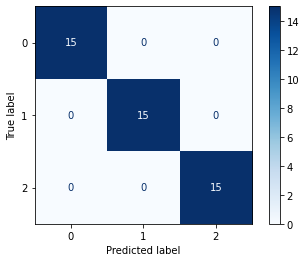

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
#print(cm)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

### | 과제 3. MNIST 숫자 데이터 분류

```
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
```

In [75]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 정규화(x)
x_train = x_train/255.0 # (0 ~ 1)
x_test = x_test/255.0 # (0 ~ 1)
# 원핫(y) -> 안하고 작동시켜보기
# One_hot 인코딩은 카테고리를 표현할 때 자주 사용하는 방법으로 X가 아닌 1차원 array 형태로 나타냅니다.
# Tensorflow에서 to_categorical()을 이용합니다.
# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* 데이터 시각화

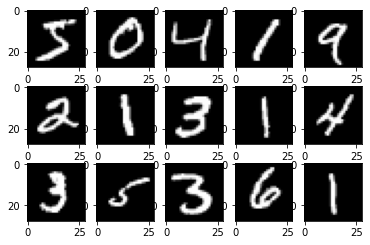

In [76]:
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(x_train[i], cmap='gray')

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-03.PNG?raw=true width=500>
</p>


#### **모델 생성**

In [89]:
# from tensorflow.keras import models, layers, utils

# def build_mnistmodel():
#     x = layers.Input(shape=(28,28), name="input")
#     y = layers.Flatten(name="flatten")(x)
#     y = layers.Dense(256, activation="relu", name="D1")(y)
#     y = layers.Dense(256, activation="relu", name="D2")(y)
#     y = layers.Dense(10, activation="softmax", name="output")(y)
#     model = models.Model(x, y)
#     return model

In [94]:
from tensorflow.keras import models, layers, utils

def build_mnistmodel():
    x = layers.Input(shape=(28,28))
    z = layers.Flatten()(x)
    z = layers.Dense(256, activation='relu')(z)
    z = layers.Dense(256, activation='relu')(z)
    y = layers.Dense(10, activation='softmax')(z)
    model = models.Model(x,y)
    return model

In [18]:
# import tensorflow as tf
# # 3. 모델 구성
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(512, activation=tf.nn.relu),
#     tf.keras.layers.Dense(10, activation=tf.nn.softmax)
# ])

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

In [95]:
model = build_mnistmodel()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               200960    
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 다중분류 문제
    * categorical_crossentropy : 원-핫 완료된 상태
    * sparse_categorical_crossentropy : 웟-핫 안된상태
* `optimizer` : Adam
* `metrics`: 

In [96]:
# 4. 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

In [97]:
# 5. 모델 훈련
model.fit(x_train, y_train, epochs=10, batch_size=50)

Epoch 1/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.2113 - accuracy: 0.9377
Epoch 2/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0851 - accuracy: 0.9739
Epoch 3/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0579 - accuracy: 0.9813
Epoch 4/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0436 - accuracy: 0.9855
Epoch 5/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0321 - accuracy: 0.9895
Epoch 6/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0288 - accuracy: 0.9905
Epoch 7/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0209 - accuracy: 0.9931
Epoch 8/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0198 - accuracy: 0.9931
Epoch 9/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0172 - accuracy: 0.9945
Epoch 10/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.016

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [98]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0968 - accuracy: 0.9779


[0.09680601209402084, 0.9779000282287598]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [99]:
y_pred = np.argmax(model.predict(x_test), axis=1)

* 예측 시각화

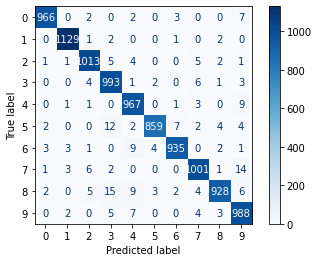

In [100]:
# 혼돈행렬 만들기
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion_matrix는 정수값이 들어가야함
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues");

* 모델 활용